# Unsupervised Learning to Predict Best Bike Station Locations

In [4]:
import geopandas
import pandas as pd
import folium

In [5]:
points = pd.read_csv('points_true.csv')
points.head()

,Unnamed: 0,Stops,geometry,x,y,populations
0,0,9,POINT (19.806613 41.34748),19.806613,41.347480,63713
1,1,8,POINT (19.814773 41.345314),19.814773,41.345314,41524
2,2,9,POINT (19.814581 41.345426),19.814581,41.345426,63713
3,3,8,POINT (19.817422 41.340773),19.817422,41.340773,41524
4,4,9,POINT (19.817399 41.34061),19.817399,41.340610,63713


## K-Means Clustering

As a first algorithm, let's use K-means clustering to make our predicitions. Below, you can find the code for buildin up these clusters of places, based on the x and y coordinates of the bus stations. I have chosen a starting point of 10 clusters. I am also adding the cluster and centroid columns to the dataset to facilitate the visualization process.

In [6]:
from sklearn.cluster import KMeans
import scipy.cluster
import seaborn as sns
import matplotlib.pyplot as plt


k = 10
model = KMeans(n_clusters=k, init='k-means++')
X = points[["x", "y"]]

dtf_X = X.copy()
dtf_X["cluster"] = model.fit_predict(X)

closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                     dtf_X.drop("cluster", axis=1).values)
dtf_X["centroids"] = 0
for i in closest:
    dtf_X["centroids"].iloc[i] = 1

model_first = model.cluster_centers_
points[["cluster","centroids"]] = dtf_X[["cluster","centroids"]]
points.sample(5)

points.sample(5)

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Unnamed: 0,Stops,geometry,x,y,populations,cluster,centroids
307,307,1,POINT (19.849142 41.327531),19.849142,41.327531,51816,8,0
225,225,2,POINT (19.847713 41.301058),19.847713,41.301058,83371,1,0
197,197,14,POINT (19.774404 41.328931),19.774404,41.328931,0,3,0
312,312,13,POINT (19.7983 41.313198),19.798300,41.313198,0,7,0
412,412,15,POINT (19.731845 41.358477),19.731845,41.358477,0,6,0


Now, let's plot the clusters and the existing bus stations.

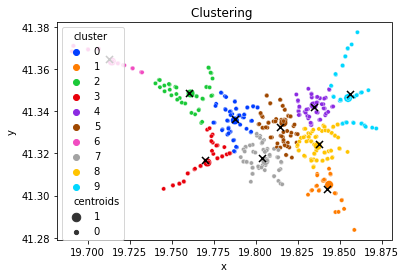

In [7]:
fig, ax = plt.subplots()
sns.scatterplot(x="x", y="y", data=points, 
                palette=sns.color_palette("bright",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend="brief", ax=ax).set_title('Clustering ')
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', 
           marker="x")

To make a bit more sense of this map, we can contextualize it in an actual geographical map of Tirana. For this we can use Folium as follows:

In [8]:
map = folium.Map(location=[41.3275, 19.8187], default_zoom_start=200)
for c in th_centroids:
    folium.Marker(
    location=[c[1], c[0]],
    icon=folium.Icon(color='red'),
    popup='Cluster Point</b>',
    tooltip = "Click for more").add_to(map)

In [9]:
map

Cool! But, are these clusters weighted, say, by population? That is, do they represent the best places for the area's respective populations? Luckily, sklearn allows us to account for this, so let's repeat the process adding the weight argument:

In [10]:
k = 10
model_two = KMeans(n_clusters=k, init='k-means++')
X = points[["x", "y"]]

dtf_X = X.copy()
dtf_X["cluster"] = model_two.fit_predict(X, sample_weight = points['populations'])

closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                     dtf_X.drop("cluster", axis=1).values)
dtf_X["centroids"] = 0
for i in closest:
    dtf_X["centroids"].iloc[i] = 1

points[["cluster","centroids"]] = dtf_X[["cluster","centroids"]]

weighted_w = model_two.cluster_centers_
 

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Below, I have plotted both sets of points to see how they would compare to each-other. And you can see there is a bit of a shift overall:

In [11]:
map = folium.Map(location=[41.3275, 19.8187], default_zoom_start=200)
for c in th_centroids:
    folium.Marker(
    location=[c[1], c[0]],
    icon=folium.Icon(color='red'),
    popup='Cluster Point</b>',
    tooltip = "Click for more").add_to(map)
for c in weighted_w:
    folium.Marker(
    location=[c[1], c[0]],
    popup='Cluster Point</b>',
    tooltip = "Click for more").add_to(map)    
    
map   

## Refining the Model

We need to evaluate the model somehow: how do we do that for unsupervised models? The first metric we will consider is the Silhouette Score, with values closer to 1 being perceived as tight clustering:

In [19]:
from sklearn.metrics import silhouette_score
labels = model.labels_
silhouette_score(X, labels, metric = 'euclidean')

0.38130174038762576

In [20]:
labels_two = model_two.labels_
silhouette_score(X, labels_two, metric = 'euclidean')

0.32002366808352517

In [21]:
from sklearn.metrics import calinski_harabasz_score
calinski_harabasz_score(X, labels)

630.9029384375914

In [23]:
calinski_harabasz_score(X, labels_two)

356.21830443639254

## Choosing the Optimal Number of Clusters:

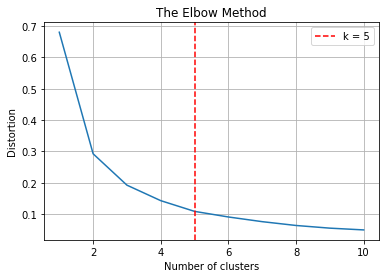

In [19]:
import numpy as np


max_k = 10
distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
        model = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        model.fit(X)
        distortions.append(model.inertia_)
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i 
     in np.diff(distortions,2)]))

fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', 
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

It appears that the best number of clusters should be 5, so let's see that mapped:

In [27]:
k = 5
model_three = KMeans(n_clusters=k, init='k-means++')
X = points[["x", "y"]]

dtf_X = X.copy()
dtf_X["cluster"] = model_two.fit_predict(X, sample_weight = points['populations'])

closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                     dtf_X.drop("cluster", axis=1).values)
dtf_X["centroids"] = 0
for i in closest:
    dtf_X["centroids"].iloc[i] = 1

points[["cluster","centroids"]] = dtf_X[["cluster","centroids"]]

weighted_wthree = model_two.cluster_centers_


map = folium.Map(location=[41.3275, 19.8187], default_zoom_start=1000)
for c in th_centroids:
    folium.Marker(
    location=[c[1], c[0]],
    icon=folium.Icon(color='red'),
    popup='Cluster Point</b>',
    tooltip = "Click for more").add_to(map)
for c in weighted_w:
    folium.Marker(
    location=[c[1], c[0]],
    popup='Cluster Point</b>',
    tooltip = "Click for more").add_to(map)    
    
for c in weighted_wthree:
    folium.Marker(
    location=[c[1], c[0]],
    icon=folium.Icon(color='green'),
    popup='Cluster Point</b>',
        tooltip = "Click for more").add_to(map) 

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [28]:
map